In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aydafrough","key":"6f11d390d25b1f8e7987d65c72badb9a"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           6042        209  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           6820        255  1.0              
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           7442        138  1.0              
joebeachcapital/top-10000-spotify-songs-1960-now            Top 10000 Songs on Spotify 1960-Now

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:46<00:00, 24.2MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.1MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from pathlib import Path
from typing import List,Dict

In [8]:
train_path=Path('chest_xray/train')
test_path=Path('chest_xray/test')
val_path=Path('chest_xray/val')


In [9]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import random
from PIL import Image

image_list=[]
image_list_path=list(test_path.glob("*/*.jpeg"))
for i in range(10):
  image_path=random.choice(image_list_path)
  image_class=image_path.parent.stem
  img=Image.open(image_path)

  image_list.append({'img':img, 'image_class':image_class})


image_list

[{'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1008x728>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=856x552>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1048x440>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1754x1377>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1112x736>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1048x688>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1528x968>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1496x960>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1344x824>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1620x

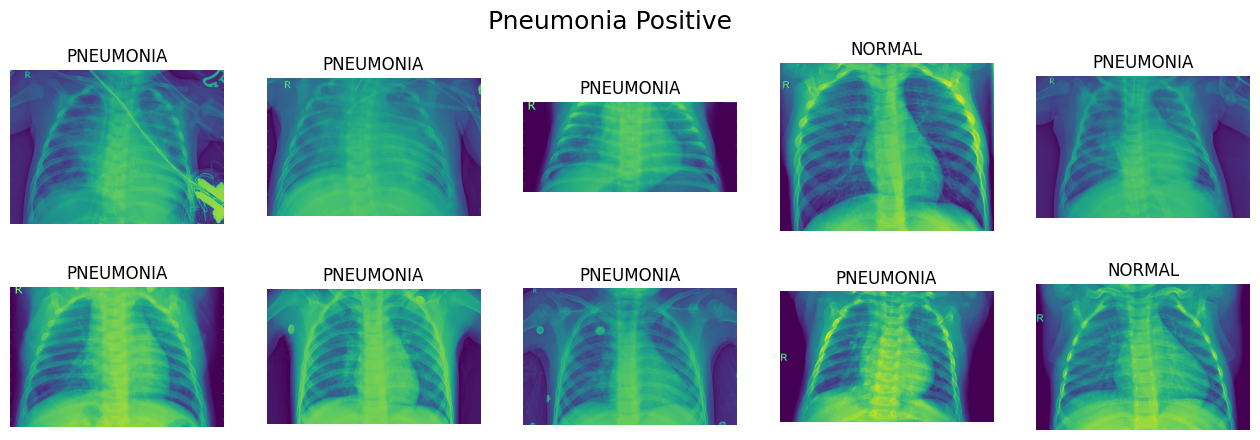

In [11]:
#visualize our data
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneumonia Positive", size=18)
for i, image in enumerate(image_list):
  #fig.add_subplot(2,5,len(image_list),frameon=False)
  plt.subplot(2,5,i+1,frameon=False)
  plt.imshow(image["img"])
  plt.title(image["image_class"])
  plt.axis(False)



fig.show()

In [12]:
#set transforms
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
data_transform= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize
])

In [13]:
#prepare datasets

train_data= datasets.ImageFolder(root=train_path,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_path,transform=data_transform)
eval_data=datasets.ImageFolder(root=val_path,transform=data_transform)


In [27]:
class_names=train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [14]:
#get the dataloaders
import os
batch_size=32
num_workers=os.cpu_count()
train_dataloader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_dataloader=DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
eval_dataloader=DataLoader(dataset=eval_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f477f39ba60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f477f39a1a0>)

models

1.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1 	86.012 /98.054 /83.6M /46.73

2.Swin_V2_T_Weights.IMAGENET1K_V1 	82.072 / 96.132 / 28.4M / 5.94

3.EfficientNet_B3_Weights.IMAGENET1K_V1 82.008 /96.054 /12.2M /1.83

4.RegNet_X_1_6GF_Weights.IMAGENET1K_V2 	79.668 /94.922 /9.2M /1.6

5.EfficientNet_V2_S_Weights.IMAGENET1K_V1  84.228 / 96.878 /21.5M /8.37


In [108]:
#weights=torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
#model=torchvision.models.regnet_y_16gf(weights=weights)

#model

In [118]:
#weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#model=torchvision.models.efficientnet_v2_s(weights=weights)

model=torchvision.models.vgg16()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [119]:
#freeze
for param in model.parameters():
  param.requires_grad=False


In [17]:
#torch info library install
! pip install torchinfo

In [120]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (6)

In [124]:
model.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1, bias=True)
  ).to(device)

summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [20]:
#install torch metrics
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 12.6 MB/s eta 0:00:00


In [125]:
from torchmetrics import Accuracy


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
accuracy=Accuracy(task='binary', num_classes=len(class_names)).to(device)


In [94]:
#train step

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn,
               optimizer:torch.optim,
               accuracy,
               device):

  train_loss,train_acc=0,0
  for batch,(x,y) in enumerate(dataloader):
    x , y = x.to(device) , y.to(device)

    logits=model(x).squeeze()
    train_pred=torch.round(torch.sigmoid(logits)).type(torch.cuda.LongTensor)
    print(y)
    print(f"train_pred:{train_pred}")


    loss=loss_fn(train_pred,y)
    train_loss +=loss.item()

    acc=accuracy(train_pred,y)
    train_acc +=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss /len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss,train_acc




In [95]:
train_loss,train_acc=train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy=accuracy,device=device)
train_loss,train_acc

tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
train_pred:tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')


RuntimeError: ignored

In [126]:
train_loss,train_acc=0,0
for epoch in range(10):
  for batch,(x,y) in enumerate(train_dataloader):
    x , y = x.to(device) , y.to(device)

    logits=model(x).squeeze()
    train_pred=torch.round(torch.sigmoid(logits))
    #print(y)
    #print(f"train_pred:{train_pred}")


    loss=loss_fn(train_pred,y.type(torch.cuda.FloatTensor))
    train_loss +=loss.item()

    acc=accuracy(train_pred,y.type(torch.cuda.FloatTensor))
    train_acc +=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss /len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)
  print(f"{train_loss},{train_acc}")

83.4346329390637,0.678680981595092
83.98963063286104,0.6793937483533441


KeyboardInterrupt: ignored